In [1]:
from google.colab import files

uploaded=files.upload()

Saving GOOGL_data.csv to GOOGL_data.csv


yt head :
0    393.0777
1    391.6012
2    390.7403
3    391.8214
4    394.3039
Name: close, dtype: float64


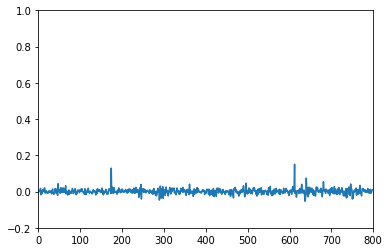

In [3]:
import numpy as np
import pandas as pd
import io
data_csv=pd.read_csv("C:\\Users\\shankhajyoti\\Dropbox\\Deepak\\GOOGL_data.csv")
data_to_use= len(data_csv)
 
# number of training data
# should be less than data_to_use
train_end =len(data_csv)-458
 
 
total_data=len(data_csv)
 
#most recent data is in the end 
#so need offset
start=total_data - data_to_use
 
 
#currently doing prediction only for 1 step ahead
steps_to_predict =1
 
  
yt = data_csv.iloc [start:total_data ,4]    #Close price
yt1 = data_csv.iloc [start:total_data ,1]   #Open
yt2 = data_csv.iloc [start:total_data ,2]   #High
yt3 = data_csv.iloc [start:total_data ,3]   #Low
vt = data_csv.iloc [start:total_data ,5]    # volume
 
 
print ("yt head :")
print (yt.head())
 
yt_ = yt.shift (-1)
    
data = pd.concat ([yt, yt_, vt, yt1, yt2, yt3], axis =1)
data. columns = ['yt', 'yt_', 'vt', 'yt1', 'yt2', 'yt3']
     
data = data.dropna()
cols =['yt']
x = data [cols]
x_train=x.loc[0:799,:] 
# we apply the bootstrap only on the training data
x_train=np.array(x_train).reshape(len(x_train),1)

p=len(x_train)
log_xtrain=np.zeros((p-1,1),dtype=float)
for j in range(p-1):
    log_xtrain[j,0]=np.log(x_train[j+1,0]/x_train[j,0])
import matplotlib.pyplot as plt
ax=plt.axes()
ax.set_xlim([0,800])
ax.set_ylim([-0.2,None])
plt.plot(log_xtrain)
plt.show()
# the logged return values seem stationary

In [6]:
from math import sqrt
def block_mse(l,arr1,arr2):
    var=0.0
    k=0
    b=len(arr1)//l
    if(b*l!=len(arr1)):
        b=b+1
        k=1
    for i in range(len(arr1)//l):
        var2=0.0
        for j in range(l):
            var2 = var2+(arr1[i*l+j,0]-arr2[i*l+j,0])/l
        var=var+var2**2
    
    if(k==1):
     var2=0.0
     for i in range((b-1)*l,len(arr1),1):
        var2=var2+(arr1[i,0]-arr2[i,0])/l
     var=var+var2**2   
     var = var/(len(arr1)//l + 1) 
    if(k == 0):
     var = var/(len(arr1)//l) 
    return(var)

6 0.00012863882579844583


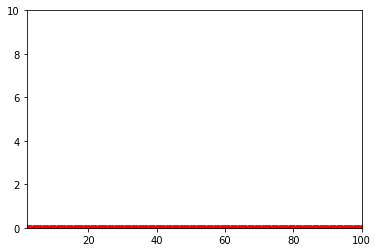

0.00025079776722434675
0.00015811510798559845
0.00014725801094800955
0.0001416798153854571
0.0001411856840525743
0.00018728639958837085
0.00022843580636683312
0.00027342162949291524
0.00034275820383527405
0.00042686632170791896
0.0005283221452490682
0.0008420747188087043
0.0010498558326849407


In [7]:
# so we resort back to our previous method of checking block mse in the range of 100  for logged returns and then finding the 
# minm block mse for the values of block length =2,4,5,8,10,16,20,25,32,40,50,80,100 as these block lengths divide the size of 
# x_train
block_lim=101

var3=0.0
n_bootstrap=1000
lmin=2 
mse_min= float("inf")
mse_arr=list()
for l1 in range(2,block_lim,1):
 var3=0.0   
 for idx in range(n_bootstrap):
  
  
  n=799
  N=n//l1
  if(n!=N*l1):
    N=N+1
  array=np.zeros((N,1),dtype=np.int)

  for i in range(N):
    array[i,0]=i
  arr=array.reshape(len(array))
  n_elements=0
  A=list()   
  while(n_elements<n):
        j=np.random.choice(arr,replace=True)
        
        if(j!=N-1):
            n_elements=n_elements+l1
            for i in range(l1):
                A.append(log_xtrain[j*l1+i,0])
        else:
            n_elements=n_elements+n-(N-1)*l1
            for i in range((N-1)*l1,n):
                A.append(log_xtrain[i,0])
  A=np.array(A).reshape(len(A),1)
  
  
  var3=var3+block_mse(l1,log_xtrain,A)
 
 mse=(var3/n_bootstrap) + ((np.log(n)/(n**2))*l1)
 mse_arr.append(mse)
 if(mse<=mse_min):
    lmin=l1
    mse_min=mse
print(lmin,mse_min)
mse_arr=np.array(mse_arr).reshape(len(mse_arr))
#z=np.linspace(2,4,1)
import matplotlib.pyplot as plt
for z in range(2,block_lim,1):
 plt.plot(z,mse_arr[z-2],'ro-')
plt.show()
for z in [2,4,5,8,10,16,20,25,32,40,50,80,100]:
    print(mse_arr[z-2])